In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shapely

import networkx as nx
import osmnx as ox
from pprint import pprint

In [3]:
# color palette for visualizing walking/biking discomfort
chosen_cmap = sns.color_palette("Spectral", as_cmap = True)

# Read data

In [4]:
folder = "01_outputs/"

Gb_edges = gpd.read_file(folder + "geofabrik_bike_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gb_nodes = gpd.read_file(folder + "geofabrik_bike_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)
Gw_edges = gpd.read_file(folder + "geofabrik_walk_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gw_nodes = gpd.read_file(folder + "geofabrik_walk_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)

In [5]:
Gb_edges.shape, Gw_edges.shape

((14878, 159), (15332, 159))

In [6]:
Gb_edges.index.is_unique, Gw_edges.index.is_unique

(True, True)

In [7]:
assumed_crs = "4326"

city_adm3_pcode = "PH137401000"

city_initial_digits = "PH137401"

In [8]:
brgy_geo = gpd.read_file("01_outputs/CCHAIN_FILTERED_brgy_geography.geojson")

brgy_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    27 non-null     object        
 1   adm4_pcode              27 non-null     object        
 2   date                    27 non-null     datetime64[ms]
 3   freq                    27 non-null     object        
 4   brgy_total_area_x       27 non-null     float64       
 5   brgy_distance_to_coast  27 non-null     float64       
 6   brgy_is_coastal         27 non-null     bool          
 7   adm1_en                 27 non-null     object        
 8   adm1_pcode              27 non-null     object        
 9   adm2_en                 27 non-null     object        
 10  adm2_pcode              27 non-null     object        
 11  adm3_en                 27 non-null     object        
 12  adm3_pcode              27 non-null     obje

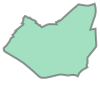

In [9]:
brgy_geo_for_city = brgy_geo.loc[brgy_geo["adm4_pcode"].str.startswith(city_initial_digits)].copy(deep = True)

city_geo = brgy_geo_for_city.union_all()
city_geo

# POIs

In [10]:
import pyrosm

In [11]:
pbf = pyrosm.OSM("external_datasets/geofabrik_filtered/filter_mandaluyong/output.osm.pbf")

In [12]:
pois = pbf.get_pois()

In [13]:
pois.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   lat               97 non-null     float32 
 1   timestamp         563 non-null    object  
 2   tags              408 non-null    object  
 3   changeset         137 non-null    float64 
 4   lon               97 non-null     float32 
 5   id                563 non-null    int64   
 6   visible           523 non-null    object  
 7   version           563 non-null    int32   
 8   addr:city         192 non-null    object  
 9   addr:housename    7 non-null      object  
 10  addr:postcode     46 non-null     object  
 11  addr:street       200 non-null    object  
 12  name              338 non-null    object  
 13  opening_hours     39 non-null     object  
 14  operator          61 non-null     object  
 15  amenity           469 non-null    object  
 16  bicycle_parking   

In [14]:
pois[["amenity", "building", "name", "osm_type"]]

,amenity,building,name,osm_type
0,parking_entrance,NaN,The Podium West Tower Car Parking,node
1,parking,NaN,BDO Corporate Center Parking,node
2,parking_entrance,NaN,None,node
3,ferry_terminal,NaN,Hulo Tawiran,node
4,None,NaN,Washers @Work,node
...,...,...,...,...
558,school,None,City of Mandaluyong Science High School,relation
559,school,None,Hulo Integrated School,relation
560,school,None,Isaac Lopez Integrated School,relation
561,parking,None,None,relation


In [15]:
# dont use this one
pois["amenity"].value_counts()

amenity
parking               101
parking_entrance       77
school                 42
place_of_worship       39
townhall               30
fuel                   27
fast_food              25
community_centre       13
bank                   12
bus_station             7
restaurant              7
social_facility         6
clinic                  6
health_post             5
shelter                 4
marketplace             4
fire_station            4
pharmacy                4
bench                   3
fountain                3
ferry_terminal          3
police                  3
university              3
college                 3
prison                  2
parking_space           2
internet_cafe           2
doctors                 2
events_venue            2
taxi                    2
mortuary                2
library                 2
hospital                2
post_depot              1
cafe                    1
motorcycle_repair       1
kindergarten            1
motorcycle_parking      1
dent

In [16]:
pois.loc[pois["bicycle_parking"].notna()]

,lat,timestamp,tags,changeset,lon,id,visible,version,addr:city,addr:housename,...,building,building:levels,internet_access,landuse,office,social_facility,wikipedia,craft,religion,trade
49,14.582158,1708836815,"{""access"":""customers"",""level"":""-1""}",0.0,121.053207,10968889169,False,2,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,14.582942,1708836815,"{""access"":""private""}",0.0,121.054283,10968889170,False,2,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


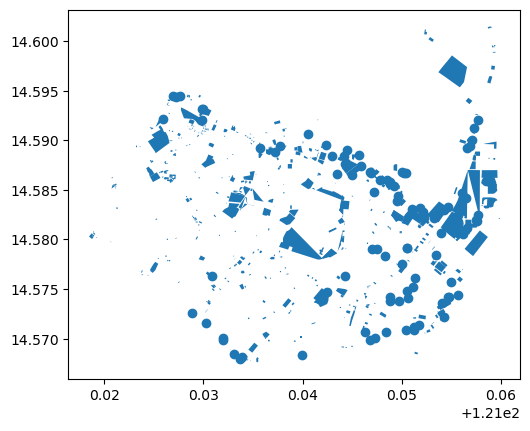

In [17]:
pois.plot(aspect = 1)

plt.show()

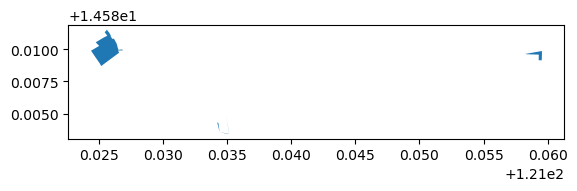

In [18]:
pois.loc[pois["amenity"] == "college"].plot(aspect = 1)

plt.show()

In [19]:
# amenity: college, school, hospital, university
# leisure: nature_reserve, park

# Land use

In [20]:
landuse = pbf.get_landuse()

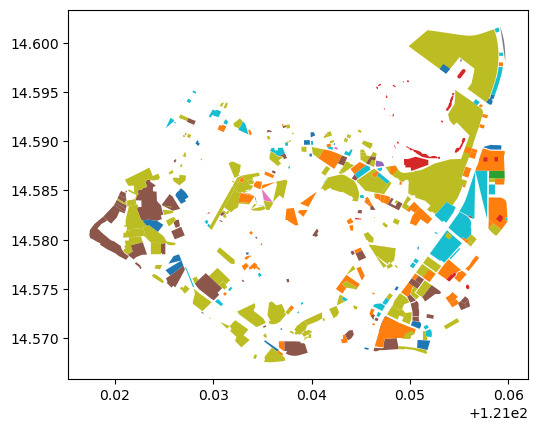

In [21]:
fig, ax = plt.subplots()

landuse.plot("landuse",
             aspect = 1, ax = ax)

plt.show()

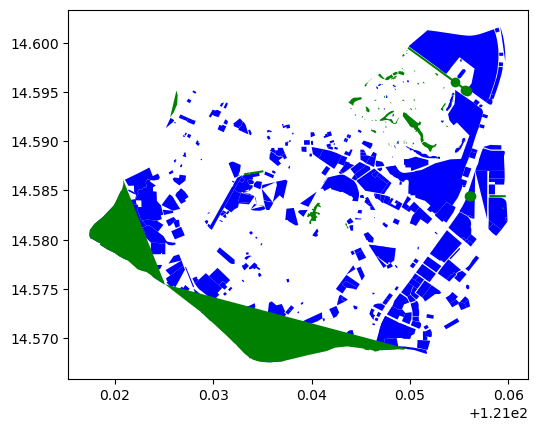

In [22]:
fig, ax = plt.subplots()

landuse.plot(#"landuse",
             aspect = 1, ax = ax, color = "blue")

pbf.get_natural().plot(aspect = 1, ax = ax, color = "green")
plt.show()

In [23]:
landuse["residential"].value_counts()

residential
apartments              29
terrace                 11
irregular_settlement     9
urban                    6
detached                 5
block                    4
gated                    1
condominium              1
apartment                1
Name: count, dtype: int64

In [24]:
landuse.head()

,construction,depot,industrial,landuse,military,residential,id,timestamp,version,tags,osm_type,geometry,changeset
0,None,None,None,retail,None,None,26468917,1251530918,7,"{""visible"":false}",way,"POLYGON ((121.04369 14.5739, 121.04343 14.5737...",NaN
1,None,None,None,residential,None,None,26474311,1653898807,23,"{""visible"":false,""is_in"":""Mandaluyong;Metro Ma...",way,"POLYGON ((121.05062 14.57666, 121.05127 14.577...",NaN
2,None,None,None,commercial,None,None,27261460,1708847698,24,"{""visible"":false,""addr:city"":""Mandaluyong"",""ad...",way,"POLYGON ((121.05963 14.58699, 121.05807 14.586...",NaN
3,None,None,None,brownfield,None,None,27788155,1625240758,12,"{""visible"":false,""addr:city"":""Mandaluyong"",""ad...",way,"POLYGON ((121.05831 14.59373, 121.05811 14.593...",NaN
4,None,None,None,greenfield,None,None,29126604,1581351298,8,"{""visible"":false}",way,"POLYGON ((121.02264 14.58204, 121.02278 14.581...",NaN


In [25]:
landuse["landuse"].value_counts(dropna = False)

landuse
residential          110
retail                50
commercial            50
industrial            46
grass                 27
brownfield            19
construction          17
religious             17
greenfield            12
cemetery               2
garages                2
institutional          2
flat                   1
recreation_ground      1
village_green          1
greenery               1
railway                1
military               1
education              1
Name: count, dtype: int64

In [26]:
landuse_categories = {
    "residential": ["residential"],
    "retail": ["retail"],
    "entertainment": ["recreation_ground", "village_green", "greenery"],
    "office": ["commercial"],
    "institutional": ["religious, institutional", "education"]
}

landuse_to_include = [
    x
    for l in landuse_categories.values()
    for x in l
]

landuse_to_include

['residential',
 'retail',
 'recreation_ground',
 'village_green',
 'greenery',
 'commercial',
 'religious, institutional',
 'education']

In [27]:
landuse_filtered = landuse.loc[landuse["landuse"].isin(landuse_to_include)].copy(deep = True)
landuse_filtered.shape

(214, 13)

In [28]:
def classify_land_use_type(a, reference_dict):
    if a in reference_dict["residential"]:
        result = "residential"
    elif a in reference_dict["retail"]:
        result = "retail"
    elif a in reference_dict["entertainment"]:
        result = "entertainment"
    elif a in reference_dict["office"]:
        result = "office"
    elif a in reference_dict["institutional"]:
        result = "institutional"
    else:
        return np.nan # this should not happen
    return result

In [29]:
landuse_filtered["LAND_USE_TYPE"] = landuse_filtered["landuse"].apply(lambda x: classify_land_use_type(x, reference_dict = landuse_categories))

landuse_filtered["LAND_USE_TYPE"].value_counts(dropna = False)

LAND_USE_TYPE
residential      110
retail            50
office            50
entertainment      3
institutional      1
Name: count, dtype: int64

# Leisure

In [30]:
download_leisure = False

if download_leisure:
    leisure = ox.features_from_place("Mandaluyong City, Philippines", tags = {"leisure": True})
    leisure.to_file("06_outputs/osmnx_leisure.geojson", driver = "GeoJSON")

In [31]:
leisure = gpd.read_file("06_outputs/osmnx_leisure.geojson")

Skipping field ways: unsupported OGR type: 1


<Axes: >

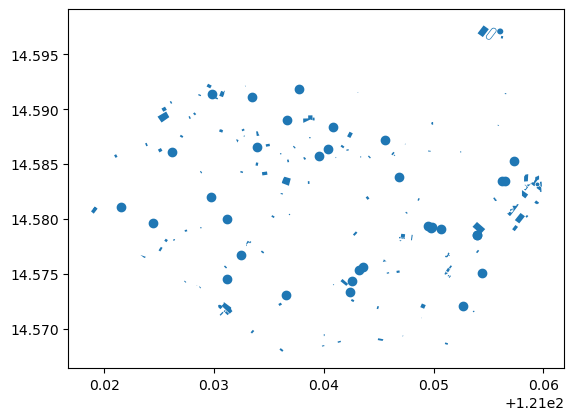

In [32]:
leisure.loc[leisure["leisure"] != "golf_course"].plot(aspect = 1)

In [33]:
leisure["leisure"].unique()

array(['pitch', 'swimming_pool', 'amusement_arcade', 'fitness_centre',
       'trampoline_park', 'sauna', 'sports_centre', 'playground',
       'fitness_station', 'outdoor_seating', 'ice_rink', 'bowling_alley',
       'sports_hall', 'park', 'golf_course', 'garden', 'track'],
      dtype=object)

In [34]:
leisure_filtered = leisure.loc[leisure["leisure"].isin(['pitch', 'swimming_pool', 'amusement_arcade', 'fitness_centre',
       'trampoline_park', 'sauna', 'sports_centre', 'playground',
       'fitness_station', 'outdoor_seating', 'ice_rink', 'bowling_alley',
       'sports_hall', 'park',
       # 'golf_course',
       'garden', 'track'])].copy(deep = True)

leisure_filtered["LAND_USE_TYPE"] = "entertainment"

leisure_filtered.shape

(168, 60)

<Axes: >

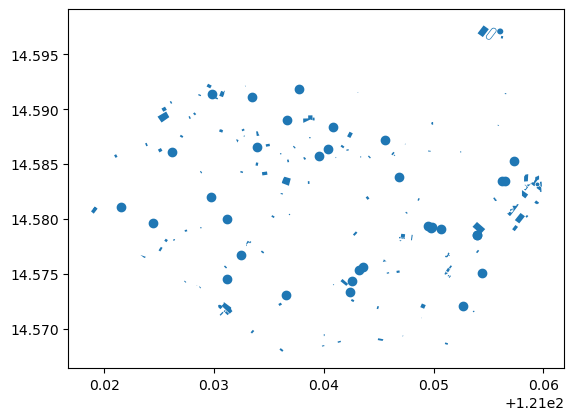

In [35]:
leisure_filtered.plot(aspect = 1)

# Amenity

In [36]:
download_amenity = False

if download_amenity:
    amenity = ox.features_from_place("Mandaluyong City, Philippines", tags = {"amenity": True})
    amenity.to_file("06_outputs/osmnx_amenity.geojson", driver = "GeoJSON")

In [37]:
amenity = gpd.read_file("06_outputs/osmnx_amenity.geojson")

Skipping field ways: unsupported OGR type: 1


<Axes: >

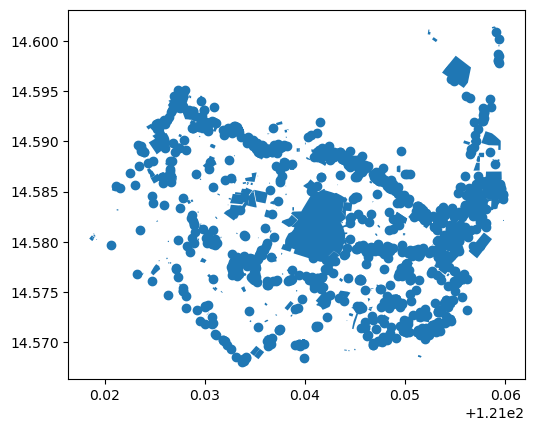

In [38]:
amenity.plot(aspect = 1)

In [39]:
amenity.shape

(1422, 276)

In [40]:
amenity.head()

,element_type,osmid,addr:city,addr:province,amenity,branch,name,osm_id,timestamp,type,...,name:tg,events_venue,building:colour,material,mapillary:map_feature,fuel:lpg,addr:state,education_program,indoor_seating,geometry
0,node,255050240,Mandaluyong,Metro Manila,police,Mandaluyong City Police Office,Police Community Precinct 2,255050240,2013-10-14 04:09:28+00:00,police,...,None,None,None,None,None,None,None,None,None,POINT (121.02983 14.58123)
1,node,255050424,Mandaluyong,None,cafe,515 Shaw Boulevard,Starbucks,None,NaT,None,...,None,None,None,None,None,None,None,None,None,POINT (121.04536 14.58805)
2,node,255055499,Mandaluyong,Metro Manila,school,None,Living Stones Christian Academy,None,NaT,None,...,None,None,None,None,None,None,None,None,None,POINT (121.04876 14.58223)
3,node,255058861,Mandaluyong,Metro Manila,college,None,Namei Polytechnic Institute,None,NaT,None,...,None,None,None,None,None,None,None,None,None,POINT (121.02342 14.5875)
4,node,255061642,Mandaluyong,Metro Manila,bank,EDSA-Shaw,Metrobank,None,NaT,None,...,None,None,None,None,None,None,None,None,None,POINT (121.05542 14.58003)


In [41]:
amenity["amenity"].value_counts(dropna = False, ascending = False)[:45]

amenity
fast_food             195
parking               143
bank                  125
restaurant            109
parking_entrance       79
cafe                   73
atm                    72
place_of_worship       56
pharmacy               54
school                 49
bicycle_parking        38
townhall               33
fuel                   27
dentist                23
community_centre       20
clinic                 18
police                 17
taxi                   16
shelter                14
toilets                12
bar                    11
fire_station           11
doctors                11
veterinary             10
social_facility         9
gambling                9
health_post             9
bench                   8
car_wash                8
college                 8
bus_station             8
post_office             8
kindergarten            7
compressed_air          7
events_venue            7
marketplace             7
recycling               6
parking_space           6
stud

In [42]:
amenity["amenity"].value_counts(dropna = False, ascending = False)[45:]

amenity
internet_cafe             4
university                3
charging_station          3
car_rental                3
clock                     3
library                   3
waste_disposal            3
pub                       3
ferry_terminal            3
fountain                  3
hospital                  2
prison                    2
waste_basket              2
mortuary                  2
vending_machine           2
rescue_station            2
payment_centre            2
cinema                    2
training                  2
post_box                  1
security_booth            1
post_depot                1
motorcycle_repair         1
healthcare                1
nightclub                 1
funeral_hall              1
events_centre             1
crematorium               1
biergarten                1
coast_guard               1
coworking_space           1
love_hotel                1
vehicle_inspection        1
fixme                     1
courthouse                1
bicycle_repa

In [43]:
residential_amenities = [] # none
retail_amenities = ["marketplace"]
entertainment_amenities = [
    "fast_food", "restaurant", "bar", "gambling", "events_venue", "internet_cafe", "library", "pub", "cinema"
]
office_amenities = ["office"]
institutional_amenities = [
    "school", "place_of_worship", "townhall", "community_centre", "social_facility", "college", "kindergarten", "driving_school", "university", "payment_centre", "bank", "courthouse", "pharmacy", "dentist", "clinic", "doctors", "veterinary", "hospital", "healthcare", "health_post", 
]

amenities_to_include = residential_amenities + retail_amenities + entertainment_amenities + office_amenities + institutional_amenities

In [44]:
amenity_filtered = amenity.loc[amenity["amenity"].isin(amenities_to_include)].copy(deep = True)

In [45]:
def classify_amenity(a):
    if a in residential_amenities:
        result = "residential"
    elif a in retail_amenities:
        result = "retail"
    elif a in entertainment_amenities:
        result = "entertainment"
    elif a in office_amenities:
        result = "office"
    elif a in institutional_amenities:
        result = "institutional"
    else:
        return np.nan # this should not happen
    return result

In [46]:
amenity_filtered["LAND_USE_TYPE"] = amenity_filtered["amenity"].apply(classify_amenity)

In [47]:
amenity_filtered["LAND_USE_TYPE"].value_counts(dropna = False)

LAND_USE_TYPE
institutional    445
entertainment    343
retail             7
office             1
Name: count, dtype: int64

In [48]:
amenity_filtered.shape

(796, 277)

<Axes: >

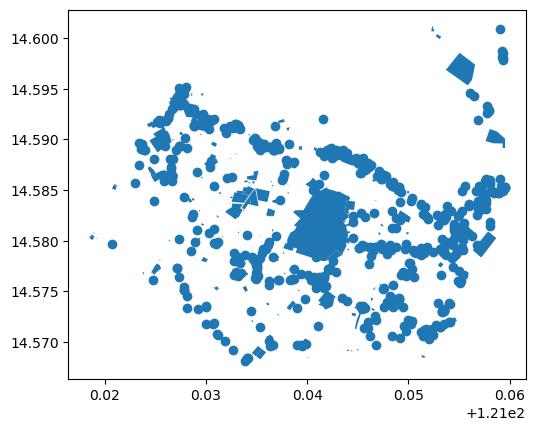

In [49]:
amenity_filtered.plot(aspect = 1)

# Buildings

In [75]:
download_buildings = False

if download_buildings:
    buildings = ox.features_from_place("Mandaluyong City, Philippines", tags = {"building": True})
    buildings.to_file("06_outputs/osmnx_buildings.geojson", driver = "GeoJSON", index = True)

In [76]:
buildings = gpd.read_file("06_outputs/osmnx_buildings.geojson").set_index(["element_type", "osmid"])

Skipping field ways: unsupported OGR type: 1


In [77]:
buildings.head()

addr:city addr:province    building  \
element_type osmid                                               
node         255053653   Mandaluyong  Metro Manila         yes   
             746042086   Mandaluyong  Metro Manila         yes   
             1664000114  Mandaluyong  Metro Manila         yes   
             3848642409         None          None  commercial   
             4807237022         None          None         yes   

                                                name   office    amenity  \
element_type osmid                                                         
node         255053653            Supersonic Mfg Inc  company       None   
             746042086   Mandaluyong Training Center     None   training   
             1664000114                      Andok's     None  fast_food   
             3848642409                  Shaw Cinema     None       None   
             4807237022         Inihaw ni Kuya Speed     None  fast_food   

                        disused level wheelchair addr:postcode  ...  \
element_type osmid                                              ...   
node         255053653     None  None       None          None  ...   
             746042086      yes  None       None          None  ...   
             1664000114    None  None       None          1550  ...   
             3848642409    None  None       None          None  ...   
             4807237022    None  None       None          None  ...   

                        building:use fuel:lpg loc_name:fil highchair  \
element_type osmid                                                     
node         255053653          None     None         None      None   
             746042086          None     None         None      None   
             1664000114         None     None         None      None   
             3848642409         None     None         None      None   
             4807237022         None     None         None      None   

                        payment:gcash payment:cards payment:credit_cards  \
element_type osmid                                                         
node         255053653           None          None                 None   
             746042086           None          None                 None   
             1664000114          None          None                 None   
             3848642409          None          None                 None   
             4807237022          None          None                 None   

                        payment:debit_cards name:zh  \
element_type osmid                                    
node         255053653                 None    None   
             746042086                 None    None   
             1664000114                None    None   
             3848642409                None    None   
             4807237022                None    None   

                                           geometry  
element_type osmid                                   
node         255053653   POINT (121.02803 14.59405)  
             746042086   POINT (121.04214 14.57813)  
             1664000114  POINT (121.05125 14.57868)  
             3848642409   POINT (121.0276 14.59329)  
             4807237022   POINT (121.0512 14.57872)  

[5 rows x 215 columns]

In [79]:
buildings.columns.to_list()

['addr:city',
 'addr:province',
 'building',
 'name',
 'office',
 'amenity',
 'disused',
 'level',
 'wheelchair',
 'addr:postcode',
 'addr:street',
 'brand',
 'brand:wikidata',
 'cuisine',
 'takeaway',
 'addr:housename',
 'operator',
 'man_made',
 'surveillance',
 'surveillance:type',
 'osm_id',
 'timestamp',
 'contact:email',
 'contact:phone',
 'contact:website',
 'shop',
 'building:levels',
 'addr:housenumber',
 'parking',
 'railway',
 'name:en',
 'source:name',
 'tourism',
 'height',
 'note',
 'access',
 'denomination',
 'religion',
 'government',
 'opening_hours',
 'townhall:type',
 'historic',
 'addr:village',
 'website',
 'brand:facebook',
 'brand:instagram',
 'brand:website',
 'brand:wikipedia',
 'check_date',
 'old_name',
 'emergency',
 'public_transport',
 'mapillary',
 'description',
 'fixme',
 'fee',
 'survey:date',
 'source',
 'addr:country',
 'addr:quarter',
 'addr:neighbourhood',
 'admin_level',
 'nodes',
 'events_venue',
 'layer',
 'leisure',
 'sport',
 'alt_name',
 'sho

In [80]:
buildings["community_centre"].value_counts(dropna = False) # ignore

community_centre
None            25560
events_place        1
Name: count, dtype: int64

In [81]:
buildings["residential"].value_counts(dropna = False) # ignore

residential
None          25560
apartments        1
Name: count, dtype: int64

In [82]:
buildings["landuse"].value_counts(dropna = False) # ignore na lang

landuse
None             25556
retail               2
commercial           1
institutional        1
military             1
Name: count, dtype: int64

<Axes: >

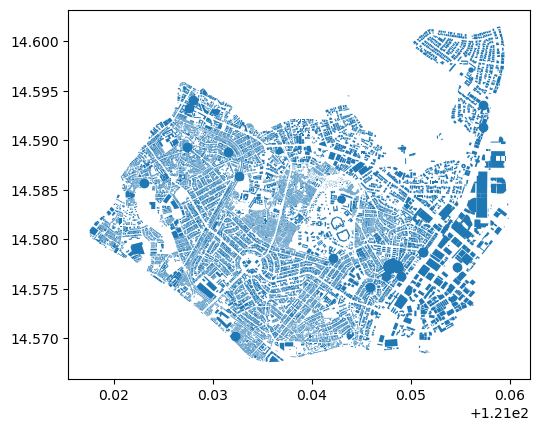

In [83]:
buildings.plot(aspect = 1)

<Axes: >

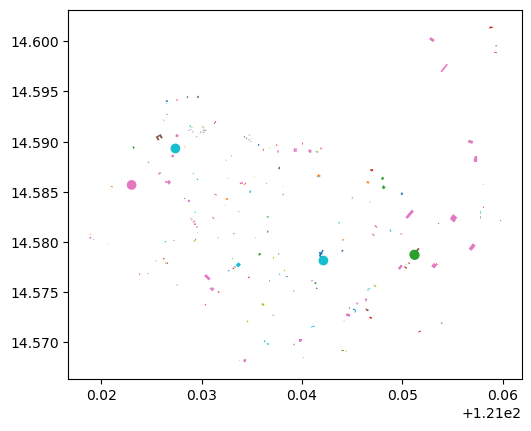

In [84]:
buildings.loc[buildings["amenity"].notna()].plot("amenity", aspect = 1)

In [85]:
buildings.geom_type.value_counts(dropna = False)

Polygon    25418
Point        143
Name: count, dtype: int64

## amenity (column)

In [86]:
buildings["amenity"].value_counts(dropna = False) # use

amenity
None                 25361
place_of_worship        38
townhall                29
fuel                    23
fast_food               19
community_centre        13
bank                    10
parking                 10
school                   7
clinic                   5
health_post              5
restaurant               5
marketplace              4
fire_station             3
pharmacy                 2
events_venue             2
police                   2
doctors                  2
mortuary                 2
library                  2
shelter                  2
internet_cafe            1
healthcare               1
dentist                  1
motorcycle_repair        1
taxi                     1
bus_station              1
prison                   1
pub                      1
social_facility          1
bar                      1
training                 1
driving_school           1
funeral_hall             1
crematorium              1
security_booth           1
Name: count, dtype: 

In [87]:
buildings_filteredbyamenity = buildings.loc[buildings["amenity"].isin(amenities_to_include)].copy(deep = True)
buildings_filteredbyamenity["LAND_USE_TYPE"] = buildings_filteredbyamenity["amenity"].apply(classify_amenity)
buildings_filteredbyamenity["LAND_USE_TYPE"].value_counts(dropna = False)

LAND_USE_TYPE
institutional    115
entertainment     31
retail             4
Name: count, dtype: int64

## building (column)

In [88]:
buildings["building"].value_counts(dropna = False) # use

building
yes               23639
house               938
residential         153
apartments          149
school              114
roof                 98
commercial           93
retail               81
terrace              48
office               39
public               31
industrial           25
civic                19
construction         17
church               16
guardhouse           16
dormitory            14
warehouse            13
chapel               12
university           10
hospital              9
parking               7
hotel                 4
detached              2
service               2
train_station         1
carport               1
storage_tank          1
container             1
toilets               1
wayside_shrine        1
gymnasium             1
transportation        1
kindergarten          1
supermarket           1
monastery             1
garage                1
Name: count, dtype: int64

In [89]:
building_col_categories = {
    "residential": ["house", "residential", "apartments", "dormitory"],
    "retail": ["retail", "supermarket"],
    "entertainment": ["gymnasium", "hotel"],
    "office": ["office", "commercial"],
    "institutional": ["public", "civic", "church", "chapel", "university", "hospital", "wayside_shrine", "monastery"]
}

building_col_to_include = [
    x
    for l in building_col_categories.values()
    for x in l
]

building_col_to_include

['house',
 'residential',
 'apartments',
 'dormitory',
 'retail',
 'supermarket',
 'gymnasium',
 'hotel',
 'office',
 'commercial',
 'public',
 'civic',
 'church',
 'chapel',
 'university',
 'hospital',
 'wayside_shrine',
 'monastery']

In [90]:
buildings_filteredbybuilding = buildings.loc[buildings["building"].isin(building_col_to_include)].copy(deep = True)
buildings_filteredbybuilding.shape

(1572, 215)

In [91]:
buildings_filteredbybuilding["LAND_USE_TYPE"] = buildings_filteredbybuilding["building"].apply(lambda x: classify_land_use_type(x, reference_dict = building_col_categories))

buildings_filteredbybuilding["LAND_USE_TYPE"].value_counts(dropna = False)

LAND_USE_TYPE
residential      1254
office            132
institutional      99
retail             82
entertainment       5
Name: count, dtype: int64

## office (column)

In [92]:
buildings["office"].value_counts(dropna = False) # use

office
None                       25532
government                    14
company                        3
religion                       3
estate_agent                   2
educational_institution        2
foundation                     2
yes                            1
water_utility                  1
telecommunication              1
Name: count, dtype: int64

In [93]:
buildings_filteredbyoffice = buildings.loc[buildings["office"].notna()].copy(deep = True)

buildings_filteredbyoffice.shape

(29, 215)

In [94]:
buildings_filteredbyoffice["LAND_USE_TYPE"] = "office"

## CONCAT

In [95]:
buildings_filteredbyoffice.index

MultiIndex([('node',  255053653),
            ('node', 6525878408),
            ( 'way',   27190233),
            ( 'way',  104217386),
            ( 'way',  126782556),
            ( 'way',  130279785),
            ( 'way',  166090893),
            ( 'way',  187468504),
            ( 'way',  218402146),
            ( 'way',  218402158),
            ( 'way',  258906968),
            ( 'way',  264693966),
            ( 'way',  278761804),
            ( 'way',  278762329),
            ( 'way',  278765310),
            ( 'way',  279273353),
            ( 'way',  279292453),
            ( 'way',  279292492),
            ( 'way',  279297699),
            ( 'way',  331031355),
            ( 'way',  331159460),
            ( 'way',  331165955),
            ( 'way',  331955682),
            ( 'way',  686321392),
            ( 'way',  686327296),
            ( 'way',  687014534),
            ( 'way',  696834899),
            ( 'way',  942439706),
            ( 'way', 1322004527)],
           na

In [96]:
combined_buildings = pd.concat(
    objs = [df[["geometry", "LAND_USE_TYPE"]] for df in [buildings_filteredbyoffice, buildings_filteredbybuilding, buildings_filteredbyamenity]],
    axis = 0,
    join = "inner"
)

combined_buildings.shape

(1751, 2)

In [97]:
combined_buildings.index.is_unique

False

In [98]:
val_counts = combined_buildings.index.to_series().value_counts(ascending = False)

val_counts[:10]

(way, 331031355)      3
(way, 218402158)      3
(way, 686321392)      3
(way, 686327296)      3
(way, 279292453)      3
(node, 6525878408)    3
(way, 264693966)      3
(way, 331165955)      3
(way, 331955682)      3
(way, 331159510)      2
Name: count, dtype: int64

In [99]:
with_repeating = combined_buildings.loc[combined_buildings.index.to_series().isin(val_counts.index)].sort_index()
with_repeating

geometry  \
element_type osmid                                                           
node         255053653                          POINT (121.02803 14.59405)   
             1664000114                         POINT (121.05125 14.57868)   
             3848642409                          POINT (121.0276 14.59329)   
             4807237022                          POINT (121.0512 14.57872)   
             6523052890                         POINT (121.02301 14.58567)   
...                                                                    ...   
way          1263985024  POLYGON ((121.02094 14.58557, 121.02115 14.585...   
             1263985030  POLYGON ((121.02119 14.58472, 121.02121 14.584...   
             1322004527  POLYGON ((121.05566 14.57703, 121.05571 14.577...   
             1322004527  POLYGON ((121.05566 14.57703, 121.05571 14.577...   
             1323566683  POLYGON ((121.0471 14.57319, 121.04704 14.5730...   

                         LAND_USE_TYPE  
element_type osmid                      
node         255053653          office  
             1664000114  entertainment  
             3848642409         office  
             4807237022  entertainment  
             6523052890  institutional  
...                                ...  
way          1263985024  institutional  
             1263985030         office  
             1322004527         office  
             1322004527         office  
             1323566683         retail  

[1751 rows x 2 columns]

In [100]:
df = with_repeating.reset_index()[["element_type", "osmid", "LAND_USE_TYPE"]].value_counts().sort_index().reset_index()
df["counter"] = 1
df

,element_type,osmid,LAND_USE_TYPE,count,counter
0,node,255053653,office,1,1
1,node,1664000114,entertainment,1,1
2,node,3848642409,office,1,1
3,node,4807237022,entertainment,1,1
4,node,6523052890,institutional,2,1
...,...,...,...,...,...
1669,way,1258850413,residential,1,1
1670,way,1263985024,institutional,2,1
1671,way,1263985030,office,1,1
1672,way,1322004527,office,2,1


In [101]:
inconsistencies_in_landuse = df.groupby(["element_type", "osmid"])[["counter"]].sum().sort_values("counter", ascending = False)
inconsistencies_in_landuse

counter
element_type osmid              
way          331165955         2
             685973768         2
             343813540         2
             686327296         2
             279292453         2
...                          ...
             330938945         1
             330938944         1
             330938943         1
             330938937         1
             1323566683        1

[1649 rows x 1 columns]

In [102]:
problems = inconsistencies_in_landuse.loc[inconsistencies_in_landuse["counter"] >= 2]
problems

counter
element_type osmid              
way          331165955         2
             685973768         2
             343813540         2
             686327296         2
             279292453         2
             686321392         2
             264693966         2
             331325034         2
             279300874         2
             331031355         2
             495568573         2
             218402158         2
             244392058         2
             610228967         2
             630269128         2
             630323930         2
             330878546         2
             330873910         2
             273200609         2
             637570846         2
             331955682         2
node         6525878408        2
way          278761802         2
             121792487         2
             112549085         2

In [103]:
has_inconsistency = combined_buildings.loc[combined_buildings.index.to_series().isin(problems.index)]

has_inconsistency.sort_index()

geometry  \
element_type osmid                                                           
node         6525878408                         POINT (121.02738 14.58931)   
             6525878408                         POINT (121.02738 14.58931)   
             6525878408                         POINT (121.02738 14.58931)   
way          112549085   POLYGON ((121.03366 14.57796, 121.03339 14.577...   
             112549085   POLYGON ((121.03366 14.57796, 121.03339 14.577...   
             121792487   POLYGON ((121.05385 14.57194, 121.05394 14.571...   
             121792487   POLYGON ((121.05385 14.57194, 121.05394 14.571...   
             218402158   POLYGON ((121.03637 14.57009, 121.03627 14.569...   
             218402158   POLYGON ((121.03637 14.57009, 121.03627 14.569...   
             218402158   POLYGON ((121.03637 14.57009, 121.03627 14.569...   
             244392058   POLYGON ((121.0368 14.57616, 121.03683 14.5760...   
             244392058   POLYGON ((121.0368 14.57616, 121.03683 14.5760...   
             264693966   POLYGON ((121.02551 14.57812, 121.02545 14.578...   
             264693966   POLYGON ((121.02551 14.57812, 121.02545 14.578...   
             264693966   POLYGON ((121.02551 14.57812, 121.02545 14.578...   
             273200609   POLYGON ((121.04159 14.58889, 121.04145 14.588...   
             273200609   POLYGON ((121.04159 14.58889, 121.04145 14.588...   
             278761802   POLYGON ((121.05005 14.5849, 121.05005 14.5846...   
             278761802   POLYGON ((121.05005 14.5849, 121.05005 14.5846...   
             279292453   POLYGON ((121.02936 14.58302, 121.02941 14.582...   
             279292453   POLYGON ((121.02936 14.58302, 121.02941 14.582...   
             279292453   POLYGON ((121.02936 14.58302, 121.02941 14.582...   
             279300874   POLYGON ((121.04132 14.576, 121.04146 14.5759,...   
             279300874   POLYGON ((121.04132 14.576, 121.04146 14.5759,...   
             330873910   POLYGON ((121.03423 14.59053, 121.03436 14.590...   
             330873910   POLYGON ((121.03423 14.59053, 121.03436 14.590...   
             330878546   POLYGON ((121.03562 14.58975, 121.03574 14.589...   
             330878546   POLYGON ((121.03562 14.58975, 121.03574 14.589...   
             331031355   POLYGON ((121.02956 14.58614, 121.02949 14.586...   
             331031355   POLYGON ((121.02956 14.58614, 121.02949 14.586...   
             331031355   POLYGON ((121.02956 14.58614, 121.02949 14.586...   
             331165955   POLYGON ((121.02618 14.59219, 121.0263 14.5921...   
             331165955   POLYGON ((121.02618 14.59219, 121.0263 14.5921...   
             331165955   POLYGON ((121.02618 14.59219, 121.0263 14.5921...   
             331325034   POLYGON ((121.02472 14.58802, 121.02478 14.587...   
             331325034   POLYGON ((121.02472 14.58802, 121.02478 14.587...   
             331955682   POLYGON ((121.0264 14.58009, 121.02644 14.5799...   
             331955682   POLYGON ((121.0264 14.58009, 121.02644 14.5799...   
             331955682   POLYGON ((121.0264 14.58009, 121.02644 14.5799...   
             343813540   POLYGON ((121.02949 14.5944, 121.02961 14.5945...   
             343813540   POLYGON ((121.02949 14.5944, 121.02961 14.5945...   
             495568573   POLYGON ((121.02321 14.58954, 121.02333 14.589...   
             495568573   POLYGON ((121.02321 14.58954, 121.02333 14.589...   
             610228967   POLYGON ((121.02651 14.59277, 121.02648 14.592...   
             610228967   POLYGON ((121.02651 14.59277, 121.02648 14.592...   
             630269128   POLYGON ((121.03306 14.57838, 121.03311 14.578...   
             630269128   POLYGON ((121.03306 14.57838, 121.03311 14.578...   
             630323930   POLYGON ((121.02889 14.59128, 121.02897 14.591...   
             630323930   POLYGON ((121.02889 14.59128, 121.02897 14.591...   
             637570846   POLYGON ((121.03028 14.59084, 121.03004 14.590...   
          

In [104]:
rows = []

for index in np.unique(combined_buildings.index):
    subset = combined_buildings.loc[combined_buildings.index == index]
    new_row = subset.iloc[0].copy(deep = True)
    val_counts = subset["LAND_USE_TYPE"].value_counts(ascending = False)
    top = val_counts.index[0]
    new_row["LAND_USE_TYPE"] = top
    rows.append(new_row)

combined_buildings_clean = gpd.GeoDataFrame(rows)
combined_buildings_clean.index.names = combined_buildings.index.names

combined_buildings_clean.index.is_unique

True

In [105]:
combined_buildings_clean.shape, len(np.unique(combined_buildings.index))

((1649, 2), 1649)

In [106]:
combined_buildings_clean.geom_type.value_counts()

Polygon    1512
Point       137
Name: count, dtype: int64

In [107]:
combined_buildings_clean

geometry  \
element_type osmid                                                           
node         255053653                          POINT (121.02803 14.59405)   
             1664000114                         POINT (121.05125 14.57868)   
             3848642409                          POINT (121.0276 14.59329)   
             4807237022                          POINT (121.0512 14.57872)   
             6523052890                         POINT (121.02301 14.58567)   
...                                                                    ...   
way          1258850413  POLYGON ((121.04172 14.57465, 121.04256 14.573...   
             1263985024  POLYGON ((121.02094 14.58557, 121.02115 14.585...   
             1263985030  POLYGON ((121.02119 14.58472, 121.02121 14.584...   
             1322004527  POLYGON ((121.05566 14.57703, 121.05571 14.577...   
             1323566683  POLYGON ((121.0471 14.57319, 121.04704 14.5730...   

                         LAND_USE_TYPE  
element_type osmid                      
node         255053653          office  
             1664000114  entertainment  
             3848642409         office  
             4807237022  entertainment  
             6523052890  institutional  
...                                ...  
way          1258850413    residential  
             1263985024  institutional  
             1263985030         office  
             1322004527         office  
             1323566683         retail  

[1649 rows x 2 columns]

In [108]:
combined_buildings_clean.geom_type.value_counts()

Polygon    1512
Point       137
Name: count, dtype: int64

In [112]:
combined_buildings.loc[combined_buildings_clean.geom_type != "Point"]

geometry  \
element_type osmid                                                           
way          27190233    POLYGON ((121.05768 14.5928, 121.05768 14.5929...   
             104217386   POLYGON ((121.03368 14.59098, 121.0337 14.5909...   
             126782556   POLYGON ((121.05649 14.58516, 121.05649 14.585...   
             130279785   POLYGON ((121.04026 14.59092, 121.0404 14.5906...   
             166090893   POLYGON ((121.03539 14.5868, 121.03529 14.5865...   
...                                                                    ...   
             1256902293  POLYGON ((121.05371 14.58182, 121.05366 14.581...   
             1257330411  POLYGON ((121.044 14.58021, 121.04401 14.58028...   
             1263985024  POLYGON ((121.02094 14.58557, 121.02115 14.585...   
relation     5519548     POLYGON ((121.03948 14.58934, 121.03948 14.588...   
             17261080    POLYGON ((121.0347 14.58495, 121.03488 14.5851...   

                         LAND_USE_TYPE  
element_type osmid                      
way          27190233           office  
             104217386          office  
             126782556          office  
             130279785          office  
             166090893          office  
...                                ...  
             1256902293  institutional  
             1257330411  institutional  
             1263985024  institutional  
relation     5519548     institutional  
             17261080    institutional  

[1611 rows x 2 columns]

# CONCAT ALL

In [164]:
combined_landuse_indicators = pd.concat(
    objs = [df[["geometry", "LAND_USE_TYPE"]] for df in [landuse_filtered, leisure_filtered, amenity_filtered, combined_buildings_clean]],
    axis = 0,
    join = "inner"
).reset_index(drop = True)

combined_landuse_indicators.shape

/Users/migs/opt/anaconda3/envs/osmnx_env2b/lib/python3.13/site-packages/geopandas/array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


(2817, 2)

In [165]:
combined_landuse_indicators

,geometry,LAND_USE_TYPE
0,"POLYGON ((121.04369 14.5739, 121.04343 14.5737...",retail
1,"POLYGON ((121.05062 14.57666, 121.05127 14.577...",residential
2,"POLYGON ((121.05963 14.58699, 121.05807 14.586...",office
3,"POLYGON ((121.02313 14.58023, 121.02367 14.579...",residential
4,"POLYGON ((121.05865 14.5846, 121.05865 14.5856...",retail
...,...,...
2812,"POLYGON ((121.04172 14.57465, 121.04256 14.573...",residential
2813,"POLYGON ((121.02094 14.58557, 121.02115 14.585...",institutional
2814,"POLYGON ((121.02119 14.58472, 121.02121 14.584...",office
2815,"POLYGON ((121.05566 14.57703, 121.05571 14.577...",office


In [166]:
combined_landuse_indicators["LAND_USE_TYPE"].value_counts(dropna = False)

LAND_USE_TYPE
residential      1364
institutional     579
entertainment     540
office            193
retail            141
Name: count, dtype: int64

<Axes: >

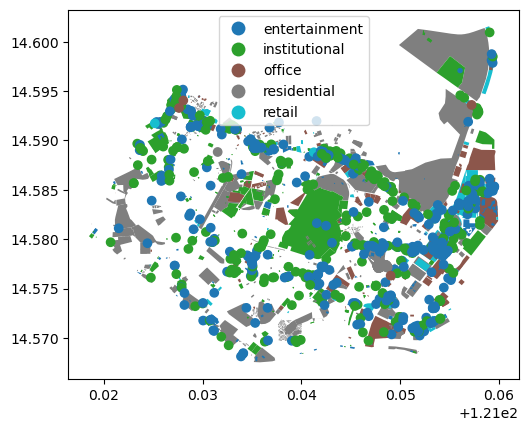

In [167]:
combined_landuse_indicators.plot("LAND_USE_TYPE", aspect = 1, legend = True)

In [168]:
combined_landuse_indicators["geom_type"] = combined_landuse_indicators["geometry"].geom_type

combined_landuse_indicators

,geometry,LAND_USE_TYPE,geom_type
0,"POLYGON ((121.04369 14.5739, 121.04343 14.5737...",retail,Polygon
1,"POLYGON ((121.05062 14.57666, 121.05127 14.577...",residential,Polygon
2,"POLYGON ((121.05963 14.58699, 121.05807 14.586...",office,Polygon
3,"POLYGON ((121.02313 14.58023, 121.02367 14.579...",residential,Polygon
4,"POLYGON ((121.05865 14.5846, 121.05865 14.5856...",retail,Polygon
...,...,...,...
2812,"POLYGON ((121.04172 14.57465, 121.04256 14.573...",residential,Polygon
2813,"POLYGON ((121.02094 14.58557, 121.02115 14.585...",institutional,Polygon
2814,"POLYGON ((121.02119 14.58472, 121.02121 14.584...",office,Polygon
2815,"POLYGON ((121.05566 14.57703, 121.05571 14.577...",office,Polygon


In [169]:
combined_landuse_indicators.to_file("06_outputs/combined_landuse_indicators.geojson", driver = "GeoJSON")

In [178]:
combined_landuse_indicators.geom_type.value_counts()

Polygon         2057
Point            750
MultiPolygon      10
Name: count, dtype: int64

# identify average building size in square meters, from the whole set of buildings in the city, not just the ones we filtered to.

In [113]:
buildings.geom_type.value_counts()

Polygon    25418
Point        143
Name: count, dtype: int64

In [116]:
buildings2 = buildings.to_crs("EPSG:25391")

In [119]:
mean_area = buildings2.loc[buildings2.geom_type != "Point", "geometry"].apply(shapely.area).mean()

mean_area

np.float64(166.39460648757125)

# check stuff

In [170]:
landuse_filtered.columns

Index(['construction', 'depot', 'industrial', 'landuse', 'military',
       'residential', 'id', 'timestamp', 'version', 'tags', 'osm_type',
       'geometry', 'changeset', 'LAND_USE_TYPE'],
      dtype='object')

In [171]:
amenity_filtered.columns.to_list()

['element_type',
 'osmid',
 'addr:city',
 'addr:province',
 'amenity',
 'branch',
 'name',
 'osm_id',
 'timestamp',
 'type',
 'addr:housenumber',
 'addr:street',
 'brand',
 'brand:wikidata',
 'brand:wikipedia',
 'cuisine',
 'official_name',
 'takeaway',
 'air_conditioning',
 'drive_through',
 'level',
 'name:en',
 'name:zh',
 'opening_hours',
 'operator',
 'addr:postcode',
 'addr:street:corner',
 'contact:phone',
 'healthcare',
 'entrance',
 'check_date',
 'short_name',
 'atm',
 'mapillary',
 'operator:wikidata',
 'operator:wikipedia',
 'dispensing',
 'email',
 'phone',
 'ref:vatin',
 'website',
 'religion',
 'addr:housename',
 'toilets',
 'wheelchair',
 'brand:wikipedia:es',
 'name:ar',
 'name:es',
 'name:ko',
 'name:ru',
 'alt_name',
 'brand:website',
 'cash_in',
 'contributor:ph',
 'opening_hours:covid19',
 'denomination',
 'service_times',
 'access',
 'barrier',
 'barrier:personnel',
 'building',
 'disused',
 'addr:unit',
 'addr:floor',
 'internet_access',
 'old_name',
 'parking',


In [172]:
leisure_filtered.columns

Index(['element_type', 'osmid', 'access', 'barrier', 'addr:city',
       'addr:housenumber', 'addr:province', 'addr:street', 'leisure', 'name',
       'sport', 'lit', 'location', 'swimming_pool', 'opening_hours', 'brand',
       'brand:wikidata', 'brand:wikipedia', 'name:en', 'addr:postcode',
       'addr:district', 'email', 'fixme', 'indoor', 'operator', 'website',
       'toilets:access', 'hoops', 'addr:floor', 'level', 'surface', 'seasonal',
       'nodes', 'building', 'events_venue', 'layer', 'source', 'check_date',
       'mapillary', 'operator:type', 'emergency:amenity',
       'emergency:social_facility', 'emergency:social_facility:for',
       'alt_name', 'community_centre', 'evacuation_center', 'amenity',
       'building:levels', 'strapline', 'building:part', 'capacity',
       'addr:building', 'addr:country', 'addr:neighbourhood', 'addr:quarter',
       'area', 'type', 'narrow', 'geometry', 'LAND_USE_TYPE'],
      dtype='object')

In [173]:
leisure_filtered["area"].value_counts(dropna = False)

area
None    167
yes       1
Name: count, dtype: int64

In [174]:
leisure_filtered.geom_type.value_counts()

Polygon    135
Point       33
Name: count, dtype: int64

In [175]:
landuse_filtered.geom_type.value_counts()

Polygon         205
MultiPolygon      9
Name: count, dtype: int64

In [176]:
amenity_filtered.geom_type.value_counts()

Point           580
Polygon         206
MultiPolygon      1
Name: count, dtype: int64

In [177]:
amenity["building"]

element_type  osmid    
node          255050240    NaN
              255050424    NaN
              255055499    NaN
              255058861    NaN
              255061642    NaN
                          ... 
relation      17310343     NaN
              17310344     NaN
              17357895     NaN
              17365641     NaN
              18137291     NaN
Name: building, Length: 1422, dtype: object